# AI2CYBER - GeoSpy

## Phase 2: Implementation - Core Model

### Objective
Implement a prototype that can:
1. Extract image features using a deep learning model (e.g., ViT, CLIP, or ResNet).
2. Predict the most likely geographical region from an image.
3. Evaluate the model using test images.

### Deliverable
A Python script or Jupyter Notebook that takes an input image and outputs the predicted region.

[Online interactive notebook - GColab](https://colab.research.google.com/drive/1AsQLSVjgykyZlqUe8E9MiLjYFW3J9_Hg?usp=sharing)

In [30]:
# Install required libraries

#!pip install transformers torch requests pillow pandas matplotlib

In [31]:
# Load required libraries

import warnings
from transformers import CLIPProcessor, CLIPModel
import torch
import requests
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

In [32]:
# Load OpenAI's CLIP model from HuggingFace

model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [33]:
# Load all continent and country labels (per continent) for zero-shot label prediction

continents_dict = {
    "Africa": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", "Chad", "Comoros", "Congo, Democratic Republic of the", "Congo, Republic of the", "Cote d'Ivoire", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"],
    "Asia": ["Afghanistan", "Armenia", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan", "Brunei", "Cambodia", "China", "Cyprus", "Georgia", "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait", "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar", "Nepal", "North Korea", "Oman", "Pakistan", "Philippines", "Qatar", "Russia", "Saudi Arabia", "Singapore", "South Korea", "Sri Lanka", "Syria", "Taiwan", "Tajikistan", "Thailand", "Timor-Leste", "Turkey", "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"],
    "Europe": ["Albania", "Andorra", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "United Kingdom", "Vatican City"],
    "North America": ["Antigua and Barbuda", "Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "El Salvador", "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States"],
    "South America": ["Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"],
    "Oceania": ["Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand", "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"]
}

# Add some exception classes for error-handling for out-of-scope input samples
exception_classes = [] #["Interior", "Portrait", "Blur", "Low Light", "Micro", "Macro", "Abstract", "Closeup", "Satellite"]

# Generate continent and country labels lists
continents_lst = exception_classes + list(continents_dict.keys())
countries_lst = exception_classes.copy()
for countries in continents_dict.values():
    countries_lst.extend(countries)

In [34]:
# Load a list of test sample locations with their ground truth labels

locations_lst = [
    ["Europe", "Greece", "Athens", "37.98677695127395, 23.7280828111323"],
    ["Europe", "Greece", "Aitoloakarnania", "38.494084850192166, 21.636578983824055"],
    ["Europe", "Netherlands", "Amsterdam", "52.35349388680577, 4.846889258299133"],
    ["Europe", "Sweden", "Linkoping", "58.395783516883455, 15.55740135463611"],
    ["Europe", "United Kingdom", "London", "51.51500389724912, -0.091617018566932"],
    ["Europe", "Italy", "Sardegna", "40.8697974435535, 9.45044645358195"],
    ["Europe", "Germany", "Berlin", "52.52231702265258, 13.409204218028203"],
    ["Asia", "Turkey", "Istanbul", "41.0066730104473, 28.94359632851977"],
    ["Asia", "Israel", "Tel Aviv", "32.04746853646404, 34.80192149673325"],
    ["Asia", "United Arab Emirates", "Abu Dhabi", "24.07925671906268, 52.848737469561684"],
    ["Asia", "United Arab Emirates", "Dubai", "25.099105148539415, 55.16815242237918"],
    ["Asia", "Japan", "Osaka", "34.7359389318495, 135.41896801150168"],
    ["North America", "United States", "Washington DC", "38.86086234670909, -77.06923602589282"],
    ["North America", "United States", "Arkansas", "34.61209405724363, -92.69412747821524"],
    ["North America", "Mexico", "Zacatecas","23.730476079518645, -101.85761918037723"],
    ["North America", "Canada", "Kamloops", "49.68053747273526, -120.60532037716854"],
    ["North America", "Mexico", "Nayarit", "21.74673316181763, -104.87118006037576"],
    ["Africa", "Botswana", "Mogapi", "-22.311771073294203, 27.84569872768147"],
    ["Africa", "South Africa", "Johannesburg", "-26.202226751394768, 28.031122936339194"],
    ["Africa", "Namibia", "Twee Rivier", "-25.507404102330455, 19.53378802387198"],
    ["Africa", "Kenya", "Kaaling", "4.212705063718347, 35.468650841861795"],
    ["Africa", "Lagos", "Nigeria", "6.595303154379424, 3.364363773701968"],
    ["Africa", "Kenya", "Katoloni", "-1.5430503635599835, 37.25204801900796"],
    ["Oceania", "Australia", "Tasmania", "-42.87728459272283, 147.31996683485684"],
    ["Oceania", "Australia", "Uluru", "-25.343894833459615, 131.02124205918219"],
    ["Oceania", "Australia", "Derby", "-17.351777717928314, 123.70575845961653"],
    ["Oceania", "New Zealand", "Wellington", "-41.28529478282324, 174.82530663940582"],
    ["Oceania", "Fiji", "Nadi", "-17.77146452557234, 177.4364392711484"],
    ["South America", "Brazil", "Rio de Janeiro", "-22.8682964965749, -43.46437629732154"],
    ["South America", "Brazil", "Machado", "-21.602955476333527, -45.88507233182359"],
    ["South America", "Peru", "Cusco", "-13.525641252837769, -71.97969323105191"],
    ["South America", "Guyana", "Georgetown", "6.658871595435498, -58.188657770442916"],
    ["South America", "Argentina", "Rio Grande", "-53.92649958963583, -68.07047772390719"]
]

# Turn list into pandas dataframe for batch processing
locations_df = pd.DataFrame(locations_lst, columns=["Continent_GT", "Country_GT", "Region_GT", "Coordinates"])

# Convert coordinates into image URLs using Google StreeView's API endpoint
locations_df['URL'] = locations_df['Coordinates'].apply(lambda coord: f"https://maps.googleapis.com/maps/api/streetview?size=600x400&location={coord}&key=GOOGLE_STREETVIEW_API_KEY")

In [35]:
# Labels validation: assert all test samples' GT labels are contained in the prediction labels lists
invalid_continents = locations_df[~locations_df['Continent_GT'].isin(continents_lst)]['Continent_GT'].unique()
if invalid_continents.size > 0:
    raise AssertionError(f"Invalid continents found in column 'Continent_GT': {invalid_continents}")

invalid_countries = locations_df[~locations_df['Country_GT'].isin(countries_lst)]['Country_GT'].unique()
if invalid_continents.size > 0:
    raise AssertionError(f"Invalid countries found in column 'Country_GT': {invalid_continents}")

In [36]:
def get_probs(url, class_lst):
    """
    This function takes an image URL and a list of classes, and returns a list of tuples containing the probability of each class for the image, sorted in descending order.

    Args:
        url (str): The URL of the image.
        class_lst (list): A list of class names (strings).

    Returns:
        list: A list of tuples, where each tuple contains a probability (float) and a class name (string). The list is sorted in descending order of probability.
    """

    # Return a list containing a single empty string `[""]` if there is an issue opening the image from the provided URL.
    try:
        image = Image.open(requests.get(url, stream=True).raw)
    except:
        return [""]

    inputs = processor(text=class_lst, images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image # Image-text similarity score
    probs = logits_per_image.softmax(dim=1).tolist() # Softmax to get the label probabilities

    class_scores = list(zip(probs[0], class_lst))
    class_scores.sort(reverse=True)

    return class_scores

In [37]:
def display_img(url):
    """
    Displays an image from a given URL.

    Args:
        url: The URL of the image to display.  This should be a valid URL
             that can be opened by the PIL (Pillow) library.  It is
             assumed that the URL points to an image file.
    """

    obj = requests.get(url, stream=True)
    image = Image.open(obj.raw)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [38]:
# Generate predictions

# Best continent prediction
locations_df['Continent_Pred'] = locations_df['URL'].apply(lambda url: get_probs(url, continents_lst)[0])
locations_df[['Continent_Score', 'Continent_Pred']] = locations_df['Continent_Pred'].apply(pd.Series)

# Best country prediction (based on best continent prediction)
def get_country_prediction(row):
    if row['Continent_Pred'] in exception_classes:
        return (0, "")
    else:
        return get_probs(row['URL'], continents_dict[row['Continent_Pred']])[0]
locations_df['Countries_Continent_Pred'] = locations_df.apply(get_country_prediction, axis=1)
locations_df[['Countries_Continent_Score', 'Countries_Continent_Pred']] = locations_df['Countries_Continent_Pred'].apply(pd.Series)

# Best country prediction (direct)
locations_df['Countries_Direct_Pred'] = locations_df['URL'].apply(lambda url: get_probs(url, countries_lst)[0])
locations_df[['Countries_Direct_Score', 'Countries_Direct_Pred']] = locations_df['Countries_Direct_Pred'].apply(pd.Series)

In [39]:
# Display predictions

locations_df[['Continent_GT', 'Continent_Pred', 'Country_GT', 'Countries_Continent_Pred', 'Countries_Direct_Pred']]

,Continent_GT,Continent_Pred,Country_GT,Countries_Continent_Pred,Countries_Direct_Pred
0,Europe,South America,Greece,Argentina,Greece
1,Europe,Europe,Greece,Albania,Albania
2,Europe,Europe,Netherlands,Netherlands,Netherlands
3,Europe,Europe,Sweden,Sweden,Sweden
4,Europe,Europe,United Kingdom,United Kingdom,United Kingdom
5,Europe,Europe,Italy,Ireland,Ireland
6,Europe,Europe,Germany,Germany,Germany
7,Asia,Europe,Turkey,Turkey,Turkey
8,Asia,Europe,Israel,Malta,Israel
9,Asia,Africa,United Arab Emirates,Mauritania,United Arab Emirates


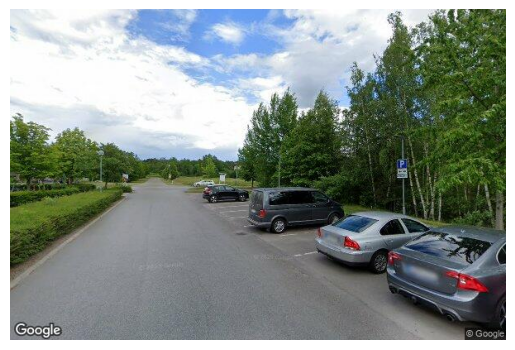

In [40]:
# Display sample image using index from locations_df

SAMPLE_INDEX = 3

display_img(locations_df['URL'].iloc[SAMPLE_INDEX])

In [41]:
def calculate_metrics(true_col, pred_col):
    """
    Calculates and prints macro-averaged F1-score, precision, and recall.

    Args:
        true_col (str): The name of the column in `locations_df` containing the true labels.
        pred_col (str): The name of the column in `locations_df` containing the predicted labels.
    """

    y_true = locations_df[true_col].values
    y_pred = locations_df[pred_col].values

    f1_macro = f1_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    print(f"{pred_col} - F1: {f1_macro} / Precision: {precision_macro} / Recall: {recall_macro}")

In [42]:
# Calculate prediction metrics for each of the 3 methods

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # Hide 0-division warnings
    calculate_metrics('Continent_GT', 'Continent_Pred')
    calculate_metrics('Country_GT', 'Countries_Continent_Pred')
    calculate_metrics('Country_GT', 'Countries_Direct_Pred')

Continent_Pred - F1: 0.6549791711556417 / Precision: 0.8200757575757575 / Recall: 0.6761904761904761
Countries_Continent_Pred - F1: 0.3333333333333333 / Precision: 0.36036036036036034 / Recall: 0.3333333333333333
Countries_Direct_Pred - F1: 0.45588235294117646 / Precision: 0.48039215686274506 / Recall: 0.45588235294117646


Continent: (0.9721508622169495, 'Europe')
Country: (0.8070113062858582, 'Czechia')


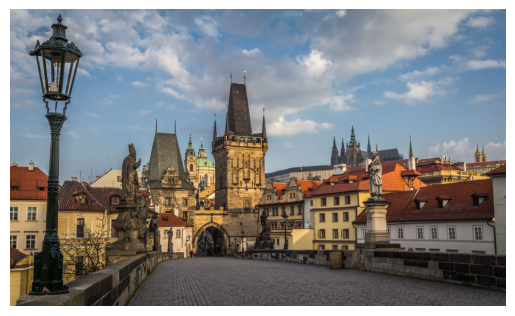

In [43]:
# Display predictions for any image on the Web

# Sample: Europe - Czech Republic - Prague
SAMPLE_IMG_URL = "https://fthmb.tqn.com/6FmFquQrNe8mFcK_MpvhFgL0Q0g=/5070x3033/filters:fill(auto,1)/czech-republic--prague--view-of-mala-strana-bridge-tower-and-prague-castle-from-charles-bridge-543346039-5967fbaf3df78c57f499c5fb.jpg"

print("Continent:", get_probs(SAMPLE_IMG_URL, continents_lst)[0])
# Disregarding country prediction based on predicted continent due to low metrics
print("Country:", get_probs(SAMPLE_IMG_URL, countries_lst)[0])

display_img(SAMPLE_IMG_URL)

In [44]:
print("Process completed successfully")

Process completed successfully
